### Training on real data

Here we train on real publicly available data.

For this example a GPU is required to train the model in reasonable time.

In [1]:
import sys
import os
sys.path.append("engine/")
sys.path.append("funcs/")
sys.setrecursionlimit(10000)

import theano.gpuarray
theano.gpuarray.use('cuda0')

import theano
import theano.tensor as T
from theano import config
import numpy as np
import pickle
import copy
import time
from itertools import *

from matplotlib import pyplot as plt
from matplotlib import gridspec
%matplotlib inline

from VIMCO_alpha import *


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/root/miniconda3/envs/spike/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7604 on context None
Mapped name None to device cuda0: Tesla V100-PCIE-32GB (0000:65:04.0)


In [2]:
config.gpu_preallcoate = 0.9

In [3]:
# home_folder = os.getenv('HOME')+'/Mackebox/Artur/WorkDB/deepspike/'

buffers = [100,40]
timebins_eval = 250
timebins = timebins_eval + sum(buffers)

samples = 64
lr = 5e-4
batch_size = 12

rng = np.random.RandomState(1)
lasagne.random.set_rng(rng)

Data

In [4]:
with open('data_prepped.pkl', 'rb') as f:
    data = pickle.load(f)
    
n_cells = 5

Traces_train = data['traces'][:n_cells]
Spikes_train = data['spikes'][:n_cells]

fps = data['fps'][:n_cells]
spikefps = data['spike_fps']

sv_Traces,sv_Spikes = data_chop(timebins, Traces_train, Spikes_train, [],fps, spikefps,50, fb=False)
sv_Spikes = [[] for _ in range(n_cells)]
test_tr_us, test_sp_us = data_chop(1798, Traces_train,  Spikes_train, None, fps, spikefps,50,fb=False)

In [5]:
test_sp_us

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr



### Parameter inference:

The most critical parameter, and also the one most variable from cell to cell is the amplitude of the response to a spike, here parametrized by alpha.

Here the recognition model infers the amplitude based on the currently observed fluroscence trace. More specifically a sample is taken from a normal distribution,
where the mean and variance are the output of the recognition model. This sample is added to the initial alpha value.

This way, during training a range of alpha values is available from which the VIMCO algorithm chooses the best ones to calculate the gradients. This stabilizes the training.

### Baseline estimation:

Real data includes fluorescence transients that are not cause by spiking activity. However our model can only explain transients using spikes.
Therefore baseline fluctuations not only induce flase positives at test time, but also degrade the quality of the training.

During training at each iteration we calculate an estimate of baseline fluctions by performing a regularized least squares regression on the residual (trace - reconstruction). 
Thise estimate of the baseline is substraced from the trace, and the loglikelihood of the reconstruction is calculated based on this 'cleaned' trace.

This way the recognition model learns to ignore baseline fluctuations without explicitly estimating them.

In [5]:
init_params = {'alpha': -1.15, 'beta': -0.0, 'c0': 0.83, 'delta_t': 1/75, 'eta': 1.84, 'gamma': -4.8, 'kappa': -2.62, 'sigma': -3.5, 'tau': 1.87}
inf_params = ['alpha']

recDict = set_rec_net([35,25,25,20,15],[51,31,21,13,11], FB = True, AR = True, n_rnn_units = 64, n_genparams=1, p_sigma = 0.3)
model = VIMCO(init_params, inf_params, ML_phys, recDict, GRUX_BernoulliRecognition,batch_size=batch_size, n_samples = samples, n_cells = n_cells, rng = rng, filename = 'gc6_model')

model.true_params = [None for _ in range(n_cells)]

model.gen_lr_fac = 3
model.lr_decay = np.array(0.995, dtype=theano.config.floatX)
model.buffers = buffers
model.facs = [3]
model.mrec.pz = 0.001
model.gradnorm_clip = 0.02
model.conc_cache = False
model.gradnorm_tot = True
model.resample = 50
model.mgen.fixed_gen = False
model.lstsq_bl = True  # Whether to use a baseline estimate during training
model.bl_lambda = 5 # Regularization parameter for the baseline regression
model.validation_score = 'synchro_0'

model.eval_sets = [{'traces':test_tr_us, 'spikes':test_sp_us, 'eval_T':1798, 'eval_rep': 5, 'test_gen':True}]

In [6]:
import time
t1 = time.time()
model.fit(sv_Traces,sv_Spikes,max_epochs= 200, learning_rate = lr, print_freq=100)
print(time.time()-t1)

/root/miniconda3/envs/spike/lib/python3.6/site-packages/theano/tensor/basic.py:5281: UserWarning: flatten outdim parameter is deprecated, use ndim instead.
  "flatten outdim parameter is deprecated, use ndim instead.")


Corr. Train: 0.346 Synchro: 0.164 || MSE Pred./Truth: 0.612 4.064 || Cost: -62.077 || Factor: 0.838 || Time upd./Eval.: 496.8 ms 3.8 s || BatchNr.: 100
Corr. Train: 0.291 Synchro: 0.173 || MSE Pred./Truth: 0.583 1.107 || Cost: -51.691 || Factor: 1.966 || Time upd./Eval.: 496.8 ms 3.8 s || BatchNr.: 200
Corr. Train: 0.305 Synchro: 0.190 || MSE Pred./Truth: 0.593 1.296 || Cost: -43.854 || Factor: 2.242 || Time upd./Eval.: 501.7 ms 3.6 s || BatchNr.: 300
Corr. Train: 0.280 Synchro: 0.181 || MSE Pred./Truth: 0.700 1.472 || Cost: -34.894 || Factor: 2.326 || Time upd./Eval.: 506.6 ms 2.2 s || BatchNr.: 400
Corr. Train: 0.289 Synchro: 0.189 || MSE Pred./Truth: 0.587 1.119 || Cost: -29.438 || Factor: 2.578 || Time upd./Eval.: 499.5 ms 2.1 s || BatchNr.: 500
Corr. Train: 0.283 Synchro: 0.196 || MSE Pred./Truth: 0.952 1.925 || Cost: -25.878 || Factor: 2.307 || Time upd./Eval.: 492.0 ms 3.7 s || BatchNr.: 600
Corr. Train: 0.277 Synchro: 0.196 || MSE Pred./Truth: 0.616 1.168 || Cost: -19.117 || Fa

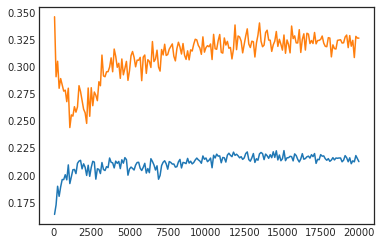

In [9]:
from plot_funcs import *
plot_od(model.col_dict['synchro_0'])
plot_od(model.col_dict['corr_0'])

Zoomed in snippet. Reconstructions based on the true spike trains is shown for a number of sampled alpha values.
Thre reconstruction based on the inferred spike train (Dark blue) is calculated using the mean alpha value.

In [ ]:
def plot_preds_bl(model, data, cell=0, pred=True, ts=[0, 1000], trace=0, figsize=None, GS=None):
    print('cr')
    n_samples = 13

    if figsize is None:
        fig = plt.figure()
    elif isinstance(figsize, tuple):
        fig = plt.figure(figsize=figsize)
    else:
        fig = figsize

    cp = sns.hls_palette(11, l=.4, s=.8)
    try:
        sr = model.superres
    except KeyError:
        sr = 1

    start = 0
    end = - 1

    fluor, spikes = data_resamp(data['traces'], data['spikes'], data['fps'], data['spike_fps'], model.resample)
    fluor = np.array(fluor[cell][trace][ts[0]:ts[1]], ndmin=2).astype(config.floatX)
    spikes = np.array(spikes[cell][trace][sr * ts[0]:sr * ts[1]], ndmin=2).astype(config.floatX)

    model.mgen.load_genparams(cell)
    rec_dict = model.mrec.get_sample(fluor, n_samples)
    pred_prob = rec_dict['Probs']
    pred_spikes = rec_dict['Spikes']
    pred_bl = 0

    
    dt = 1 / model.resample / sr
    c = 1
    t = np.arange(len(fluor[0, start:end])) * dt
    t_sr = np.arange(len(fluor[0, start:end]) * sr) * dt / sr
    
    if model.mrec.n_genparams:
        pred_pars = rec_dict['Params']

    pred_prob = pred_prob[:, sr * start:sr * end:sr].mean(axis=0)
    if pred:
        if model.mrec.n_genparams:
            pred_fluor = model.mgen.genfunc(pred_spikes, pred_pars)[:, sr * start:sr * end:sr] + pred_bl
            pred_truth = model.mgen.genfunc(np.repeat(spikes, n_samples, 0), pred_pars)[:, sr * start:sr * end:sr]
        else:
            pred_fluor = model.mgen.genfunc(pred_spikes)[:, sr * start:sr * end:sr] + pred_bl
            pred_truth = model.mgen.genfunc(np.repeat(spikes, 1, 0))[:, sr * start:sr * end:sr]

    pred_spikes = pred_spikes[:, sr * start:sr * end:sr]
    
    s_spikes = np.sum(np.squeeze(pred_prob))
    r_spikes = np.sum(spikes[0, sr * start:sr * end])
    corr = np.corrcoef(rebin(np.squeeze(pred_prob), 3), rebin(spikes[0, sr * start:sr * end], 3))[0, 1]

    pred_inds = [np.where(pred_spikes[i])[0] for i in range(13)]
    

    if GS is None:
        gs = gridspec.GridSpec(3, 1, height_ratios=([3, 1, 1]))
    else:
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=GS, height_ratios=([2, 1]), hspace=0.)

    axes = []
    for i in range(3):
        axes.append(plt.Subplot(fig, gs[i]))
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        fig.add_subplot(axes[i])

    if GS is None: gs.tight_layout(fig, h_pad=-1.8, rect=(0, 0, 0.7, 1))

    where = np.where(spikes[0, sr * start:sr * end] == 1)[0]
    where2 = np.where(spikes[0, sr * start:sr * end] > 1)[0]
    
    

    dt = 1 / model.resample / sr

    c = 1
    t = np.arange(len(fluor[0, start:end])) * dt
    t_sr = np.arange(len(fluor[0, start:end]) * sr) * dt / sr
    # print('c')
    for i in where:
        i *= dt
        if c == 1: axes[0].axvline(i, ymin=0., ymax=.1, color='black', label='True Spikes'); c = 0;
        axes[0].axvline(i, ymin=0., ymax=.1, color='black')  # , linestyle='dotted')
        axes[1].axvline(i, color='0.75')  # 灰色
    axes[0].set_xlim([0, t[-1]])
    axes[1].set_xlim([0, t[-1]])
    axes[1].set_ylim([0, 1])
    
    
    for i in where2:
        i *= dt
        axes[0].axvline(i, ymin=0., ymax=.2, color='black')
        axes[1].axvline(i, color='0.75')

    for ith, trial in enumerate(pred_inds):
        axes[2].vlines(trial * dt, ith + .5, ith + 1.5, color=cp[0])
    axes[2].set_xlim([0, t[-1]])

    axes[1].set_ylabel('Predicted Probability', fontsize=12)
    axes[1].set_xlabel('Time in Seconds', fontsize=12)
    axes[1].plot(t_sr, pred_prob, color=cp[6])
    axes[0].plot(t, fluor[0, start:end], label="Trace", color=cp[4])
    # [axes[0].plot(t, pred_truth[i], label="Prediction | True Spiketrain", linewidth=2) for i in range(len(pred_truth))]
    axes[0].plot(t, pred_fluor.mean(0), label="Prediction | Inferred Spiketrain", color=cp[7], linewidth=3)
    axes[0].legend(loc='upper left', fontsize=12)
    axes[1].text(0.75 * t[-1], 0.85, 'Corr: ' + '{:0.2f}'.format(corr), fontsize=12)
    axes[1].text(0.75 * t[-1], 0.65, 'Spikes: ' + '{:0.2f}'.format(s_spikes) + ' / ' + str(r_spikes), fontsize=12)
    # print('r')
    return t_sr, pred_prob, pred_spikes, pred_inds

In [ ]:
def plot_preds_bl_cr(model, data, cell=0, pred=True, ts=[0, 1000], trace=0, figsize=None, GS=None):
    print('cr')
    n_samples = 13

    if figsize is None:
        fig = plt.figure()
    elif isinstance(figsize, tuple):
        fig = plt.figure(figsize=figsize)
    else:
        fig = figsize

    cp = sns.hls_palette(11, l=.4, s=.8)
    try:
        sr = model.superres
    except KeyError:
        sr = 1

    start = 0
    end = - 1

    fluor, spikes = data_resamp(data['traces'], data['spikes'], data['fps'], data['spike_fps'], model.resample)
    fluor = np.array(fluor[cell][trace][ts[0]:ts[1]], ndmin=2).astype(config.floatX)
    spikes = np.array(spikes[cell][trace][sr * ts[0]:sr * ts[1]], ndmin=2).astype(config.floatX)

    model.mgen.load_genparams(cell)
    rec_dict = model.mrec.get_sample(fluor, n_samples)
    pred_prob = rec_dict['Probs']
    pred_spikes = rec_dict['Spikes']
    pred_bl = 0

    
    dt = 1 / model.resample / sr
    c = 1
    t = np.arange(len(fluor[0, start:end])) * dt
    t_sr = np.arange(len(fluor[0, start:end]) * sr) * dt / sr
    
    if model.mrec.n_genparams:
        pred_pars = rec_dict['Params']

    pred_prob = pred_prob[:, sr * start:sr * end:sr].mean(axis=0)
    if pred:
        if model.mrec.n_genparams:
            pred_fluor = model.mgen.genfunc(pred_spikes, pred_pars)[:, sr * start:sr * end:sr] + pred_bl
            pred_truth = model.mgen.genfunc(np.repeat(spikes, n_samples, 0), pred_pars)[:, sr * start:sr * end:sr]
        else:
            pred_fluor = model.mgen.genfunc(pred_spikes)[:, sr * start:sr * end:sr] + pred_bl
            pred_truth = model.mgen.genfunc(np.repeat(spikes, 1, 0))[:, sr * start:sr * end:sr]

    pred_spikes = pred_spikes[:, sr * start:sr * end:sr]
    
    s_spikes = np.sum(np.squeeze(pred_prob))
    r_spikes = np.sum(spikes[0, sr * start:sr * end])
    corr = np.corrcoef(rebin(np.squeeze(pred_prob), 3), rebin(spikes[0, sr * start:sr * end], 3))[0, 1]

    pred_inds = [np.where(pred_spikes[i])[0] for i in range(13)]
    
    
    return t_sr, pred_prob, pred_spikes, pred_inds


In [5]:
import torch
model_new = torch.load('../model.pt')

cr


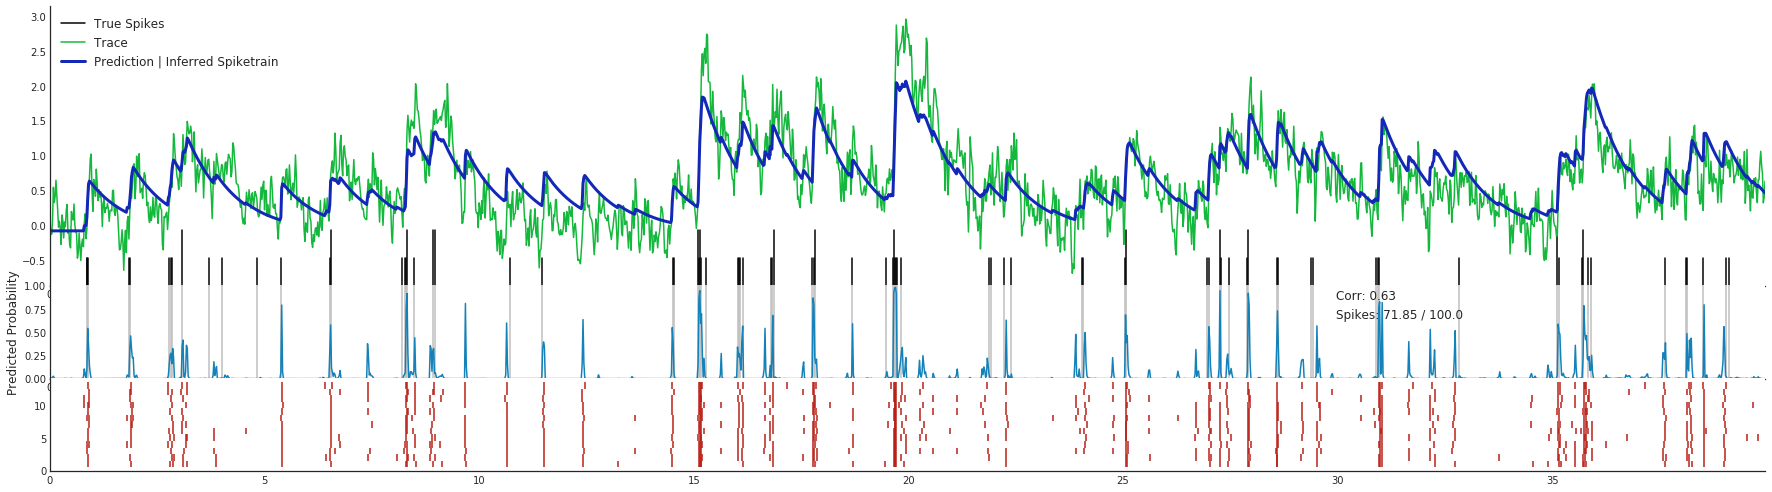

In [10]:
plot_preds_bl(model_new,data,cell=1,trace=0,figsize=(35,7),ts=[0,2000])

cr


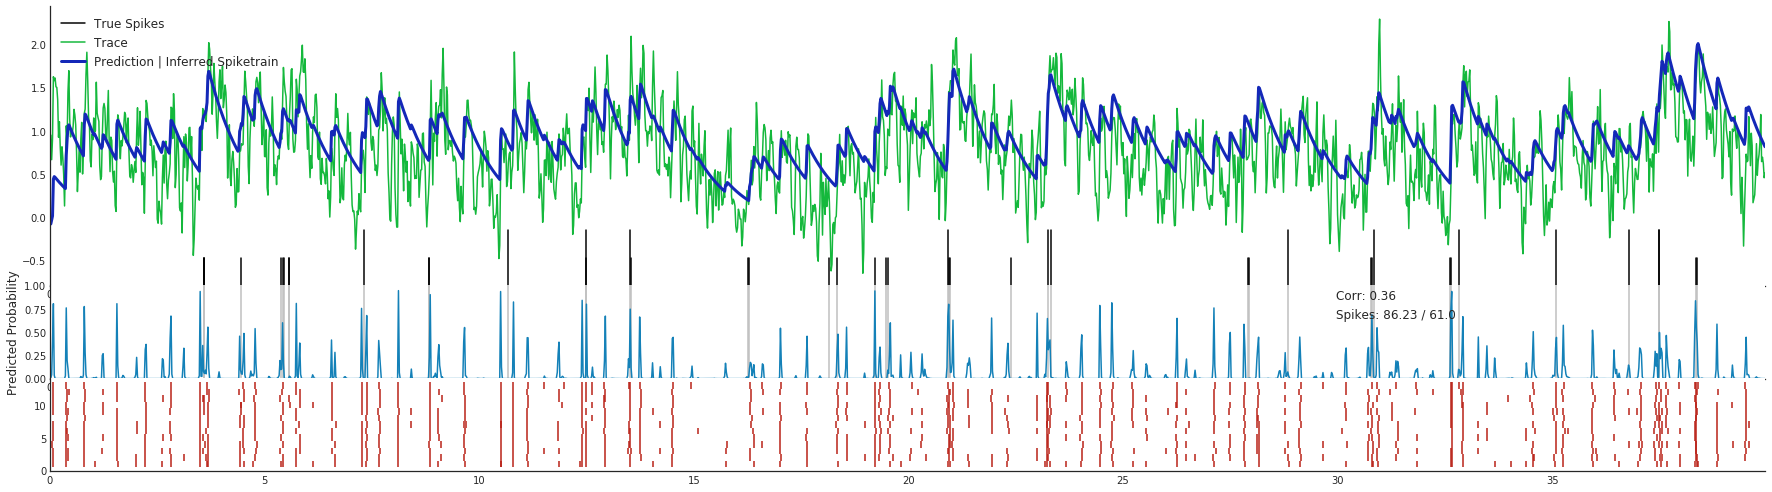

In [11]:
plot_preds_bl(model_new,data,cell=1,trace=1,figsize=(35,7),ts=[0,2000])

cr


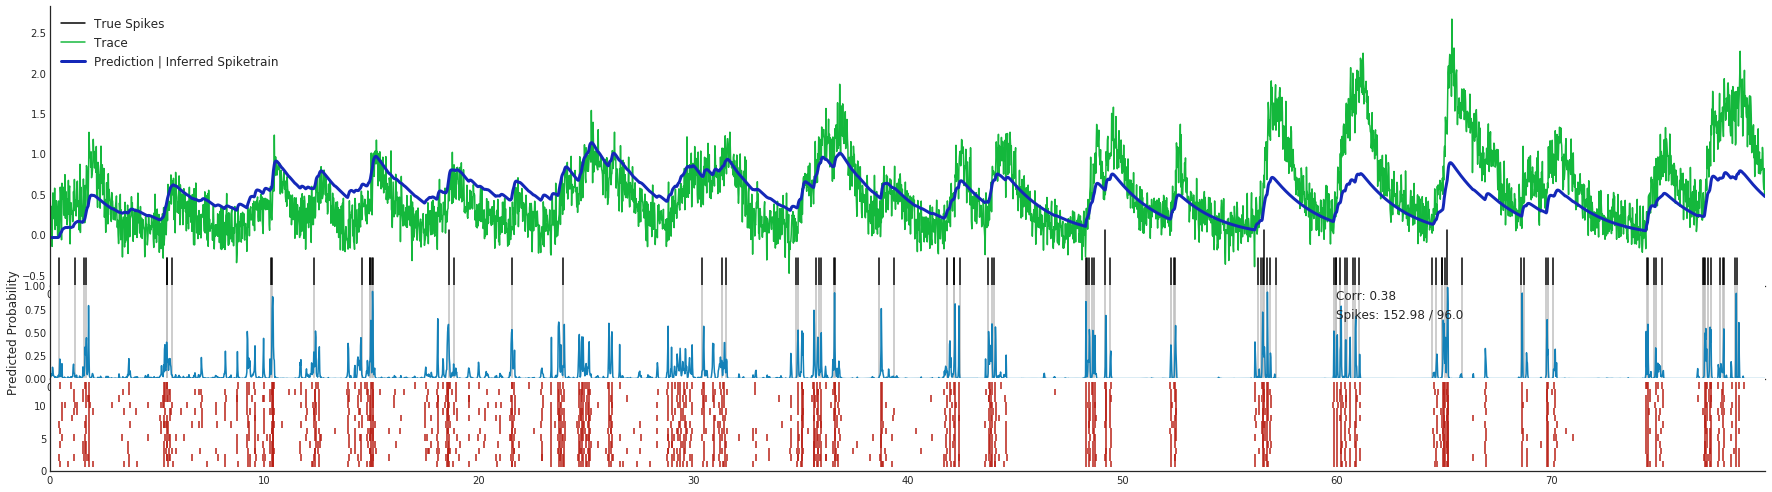

In [25]:
plot_preds_bl(model_new,data,cell=2,trace=0,figsize=(35,7),ts=[0,4000])

cr


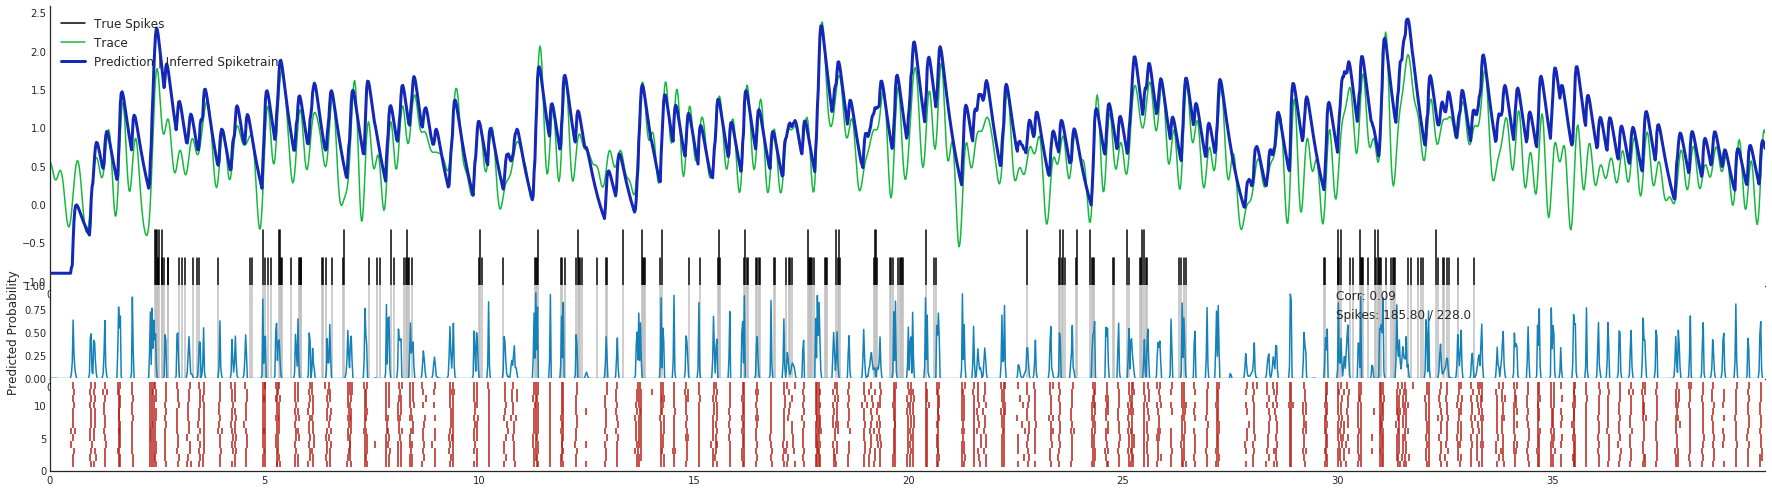

In [9]:
plot_preds_bl(model_new,data,cell=3,trace=0,figsize=(35,7),ts=[0,2000])

cr


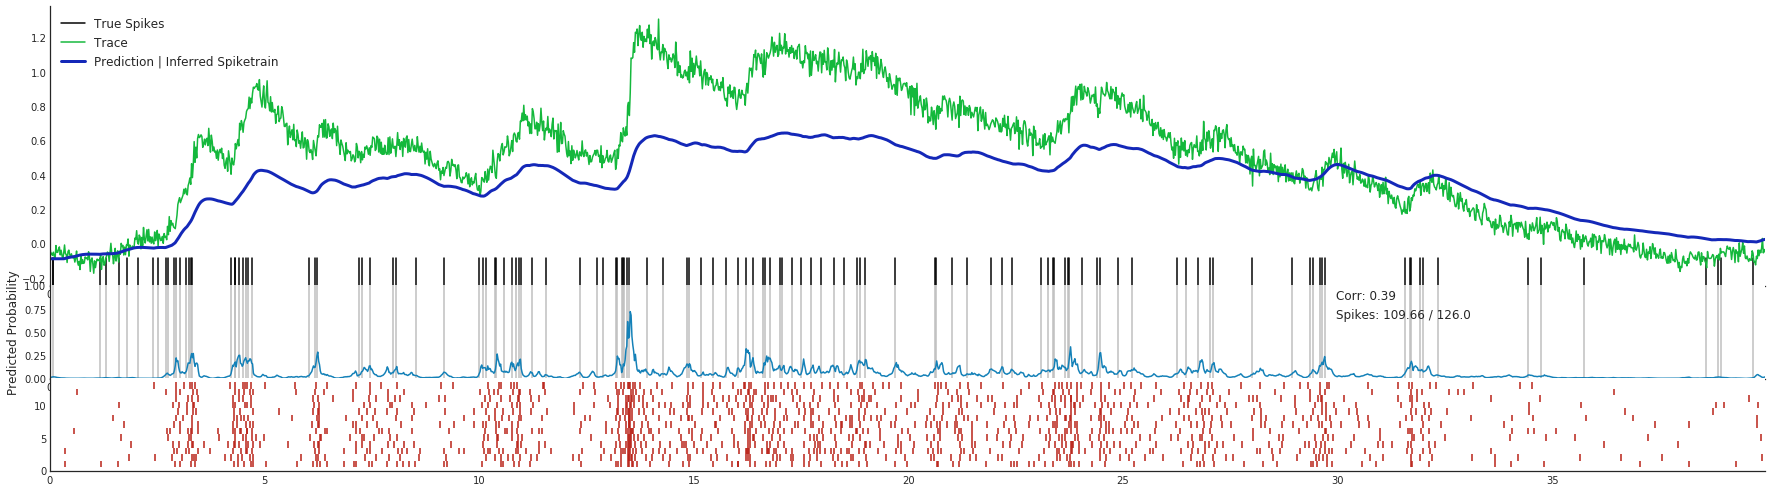

In [21]:
plot_preds_bl(model_new,data,cell=4,trace=0,figsize=(35,7),ts=[0,2000])

Results on all traces.

In [66]:
# for c in range(5):
#     print('Cell ', c)
#     for t in range(len(Traces_train[c])):
#         plot_preds_bl(model,data,c,trace=t,figsize=(35,7),ts=[0,20000])
#         plt.show()